# Demonstrating how to inference ICRT

In [1]:
%load_ext autoreload
%autoreload 2
import h5py
import numpy as np
from icrt.models.policy.icrt_wrapper import ICRTWrapper
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import trange
from IPython.display import HTML

## Construct the model 

In [2]:
checkpoint_path = "../checkpoints/icrt_vitb_droid_pretrained/icrt_vitb_droid_pretrained.pth"
train_yaml_path = "../checkpoints/icrt_vitb_droid_pretrained/run.yaml"
vision_encoder_path = "../checkpoints/crossmae_rtx/cross-mae-rtx-vitb.pth"
# llama is located at /home/mfu/checkpoints/llama-2/llama-2-7b, specified by the run.yaml file

In [3]:
icrt = ICRTWrapper(train_yaml_path, checkpoint_path, vision_encoder_path)

using vision encoder ../checkpoints/crossmae_rtx/cross-mae-rtx-vitb.pth


/home/mfu/miniconda3/envs/icrt/lib/python3.10/site-packages/timm/models/_helpers.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path

language model args: ModelArgs(dim=768, n_layers=12, n_heads=12, vocab_size=-1, multiple_of=256, norm_eps=1e-05, max_batch_size=1, max_seq_len=1024, w_bias=False, w_lora=False, lora_rank=4)
initializing main transformer ...


/home/mfu/miniconda3/envs/icrt/lib/python3.10/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


initialization completed. 
No action scaling applied
vision transform:  Compose(
    Resize(size=248, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
trainable:  91591932
Total params:  177389052
percentage trainable:  0.5163336235654498
loading pretrained model from:  ../checkpoints/icrt_vitb_droid_pretrained/icrt_vitb_droid_pretrained.pth


/home/mfu/icrt/icrt/util/misc.py:325: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location='cpu')


Load checkpoint ../checkpoints/icrt_vitb_droid_pretrained/icrt_vitb_droid_pretrained.pth
Missing keys:  []
Unexpected keys:  []


## Example to visualize the dataset

In [4]:
def get_data_from_h5(data, episode_name, resolution=(180, 320, 3), return_PIL_images=False):
    # img, action and proprio keys can be found in config/dataset_config_template.yaml
    side_images = data[f"{episode_name}/observation/exterior_image_1_left"][:]
    wrist_images = data[f"{episode_name}/observation/wrist_image_left"][:]

    action_keys = ["action/cartesian_position", "action/gripper_position"]
    proprio_keys = ["observation/cartesian_position", "observation/gripper_position"] 
    actions = np.concatenate([data[f"{episode_name}/{key}"][:] for key in action_keys], axis=-1)
    proprios = np.concatenate([data[f"{episode_name}/{key}"][:] for key in proprio_keys], axis=-1)

    side_images_l, wrist_images_l = [], []
    selected_idx = []
    for idx, (si, wi) in enumerate(zip(side_images, wrist_images)):
        if len(si) == 0 or len(wi) == 0:
            continue
        side_images_l.append(np.frombuffer(si, dtype="uint8").reshape(resolution))
        wrist_images_l.append(np.frombuffer(wi, dtype="uint8").reshape(resolution))
        selected_idx.append(idx)

    # update the actions and proprios
    actions = actions[selected_idx]
    proprios = proprios[selected_idx]

    side_images_l = np.array(side_images_l)
    wrist_images_l = np.array(wrist_images_l)

    if return_PIL_images:
        side_images_l = [Image.fromarray(side_images_l[i]) for i in range(side_images_l.shape[0])]
        wrist_images_l = [Image.fromarray(wrist_images_l[i]) for i in range(wrist_images_l.shape[0])]

    return {
        "side_images": side_images_l,
        "wrist_images": wrist_images_l,
        "actions": actions,
        "proprios": proprios
    }

In [5]:
## Visualize the Dataset 
dataset_path = "/old_home_that_will_be_deleted_at_some_point/mfu/dataset/icrl_data/multi_task_dataset/icrl_new_data_output/r2d2.hdf5"
data = h5py.File(dataset_path, "r")
resolution = (180, 320, 3)

# Load the dataset
# episode_name = list(data.keys())[0]
episode_name = "real_episode_2024-05-31-tiger-to-black-bowl_5"
print("selected episode: ", episode_name) 

obs_dict = get_data_from_h5(data, episode_name, resolution)
side_images_l, wrist_images_l, proprios, actions = obs_dict["side_images"], obs_dict["wrist_images"], obs_dict["proprios"], obs_dict["actions"]

selected episode:  real_episode_2024-05-31-tiger-to-black-bowl_5


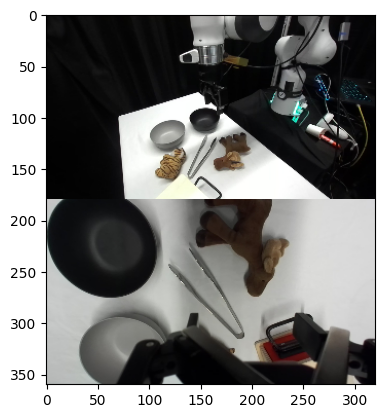

In [6]:
frames = np.concatenate([side_images_l, wrist_images_l], axis=1)
T = frames.shape[0]

fig, ax = plt.subplots()
img = ax.imshow(frames[0])

def update(frame):
    img.set_data(frame)
    return [img]

ani = animation.FuncAnimation(fig, update, frames=frames, interval=50, blit=True)

In [2]:
# # visualization of the dataset
# HTML(ani.to_jshtml())

## Forward pass of ICRT
Here we show an example of how to run inference using the ICRTWrapper. 

In [7]:
side_images = [Image.fromarray(side_images_l[i]) for i in range(side_images_l.shape[0])]
wrist_images = [Image.fromarray(wrist_images_l[i]) for i in range(wrist_images_l.shape[0])]
icrt.reset() 
action = icrt(
    side_images[0], wrist_images[0], 
    proprios[:1], 
    use_temporal=False
)

In [8]:
print(action)
diff = np.linalg.norm(actions[0] - action)
print("Difference: ", diff)

[ 0.50450641  0.01848088  0.37034824 -3.10018985 -0.01437706  0.034644
  0.12109375]
Difference:  0.13019437083582694


In [9]:
icrt.reset()
pred_actions = []
for i in trange(len(side_images)):
    if i == 0:
        action = None
    else:
        action = actions[i-1:i]
    action = icrt(
        side_images[i], wrist_images[i], 
        proprios[i:i+1], 
        action=action,
        use_temporal=False,
        teacher_forcing=True
    )
    pred_actions.append(action)

100%|██████████| 117/117 [00:07<00:00, 15.34it/s]


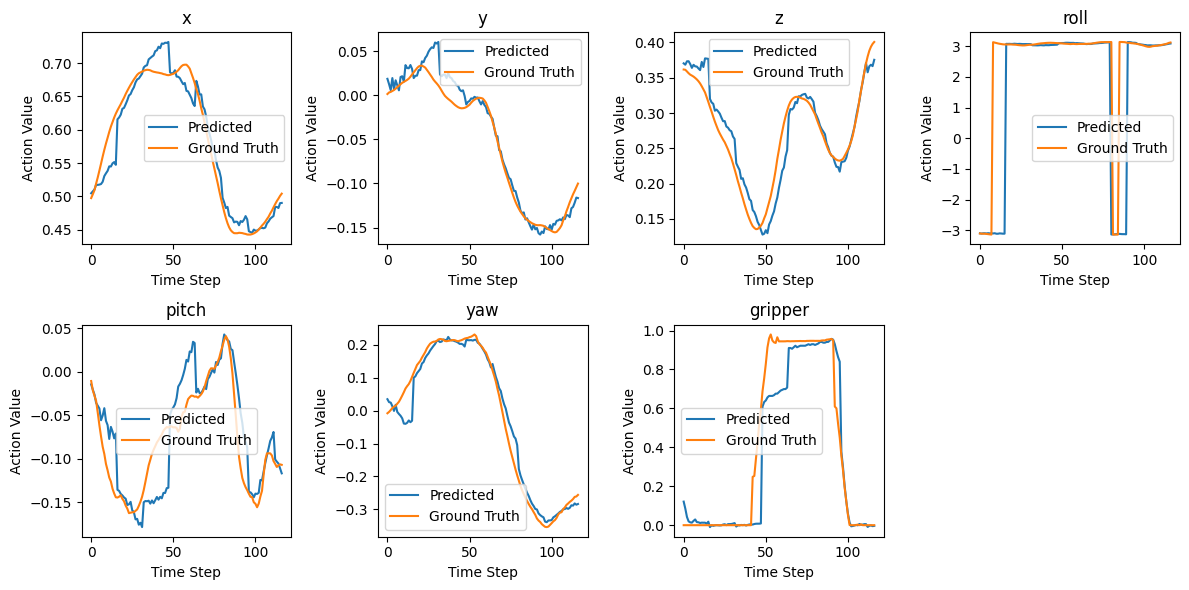

In [10]:
# plot the predicted actions and ground truth actions for each axis, (x,y,z,r,p,y,gripper)
pred_actions = np.array(pred_actions)

action_keys = ["x", "y", "z", "roll", "pitch", "yaw", "gripper"]

T = pred_actions.shape[0]
plt.figure(figsize=(12, 6))
for i in range(7):
    plt.subplot(2, 4, i+1)
    plt.plot(range(T), pred_actions[:, i], label='Predicted')
    plt.plot(range(T), actions[:, i], label='Ground Truth')
    plt.xlabel('Time Step')
    plt.ylabel('Action Value')
    plt.title(action_keys[i])
    plt.legend()

plt.tight_layout()
plt.show()


## Prompting
Below we provide an example of how to prompt with a trajectory. When rolling out on the robot, make sure to set `teacher_forcing=False` and `action=None`, since we don't have the ground truth action, and the previously generated action is cached by `ICRTWrapper`. 

In [24]:
episode_name = "real_episode_2024-05-31-tiger-to-black-bowl_5"
print("selected episode: ", episode_name) 

obs_dict = get_data_from_h5(data, episode_name, resolution, return_PIL_images=True)
side_images, wrist_images, proprios, actions = obs_dict["side_images"], obs_dict["wrist_images"], obs_dict["proprios"], obs_dict["actions"]

icrt.reset() # do not cache history for this example
icrt.prompt(
    side_images, 
    wrist_images, 
    proprios,
    actions,
)

selected episode:  real_episode_2024-05-31-tiger-to-black-bowl_5


In [25]:
episode_name = "real_episode_2024-05-31-tiger-to-black-bowl_0"
print("selected episode: ", episode_name) 

obs_dict = get_data_from_h5(data, episode_name, resolution, return_PIL_images=True)
side_images, wrist_images, proprios, actions = obs_dict["side_images"], obs_dict["wrist_images"], obs_dict["proprios"], obs_dict["actions"]

pred_actions = []
for i in trange(len(side_images)):
    if i == 0:
        action = None
    else:
        action = actions[i-1:i]
    action = icrt(
        side_images[i], wrist_images[i], 
        proprios[i:i+1], 
        action=action,
        use_temporal=False,
        teacher_forcing=True
    )
    pred_actions.append(action)

selected episode:  real_episode_2024-05-31-tiger-to-black-bowl_0


100%|██████████| 107/107 [00:06<00:00, 17.36it/s]


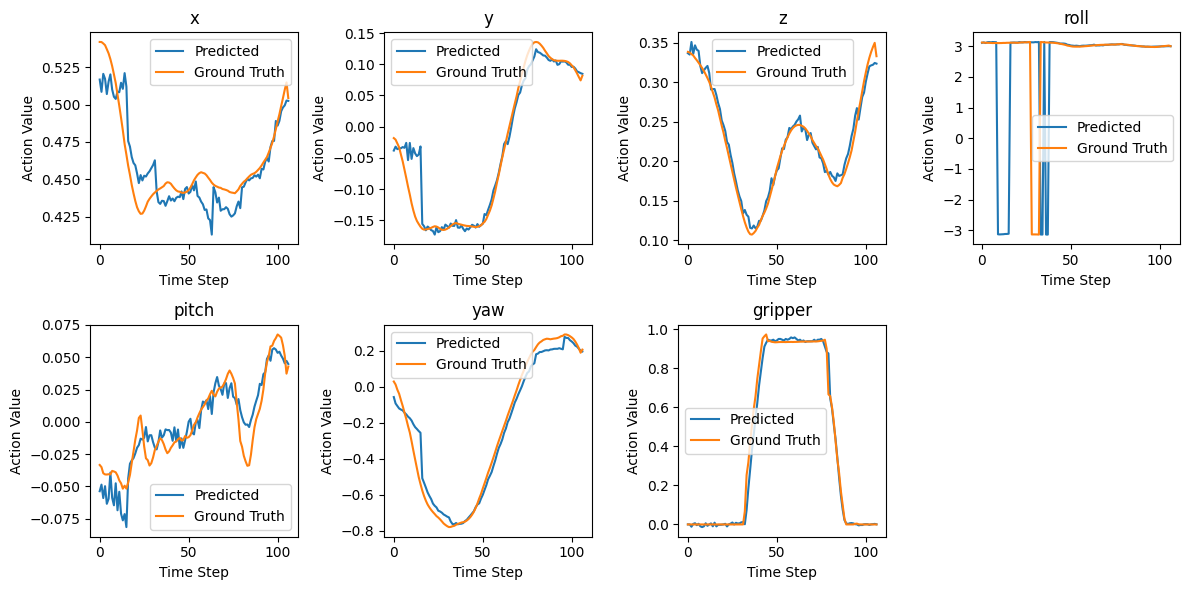

In [26]:
# plot the predicted actions and ground truth actions for each axis, (x,y,z,r,p,y,gripper)
pred_actions = np.array(pred_actions)

action_keys = ["x", "y", "z", "roll", "pitch", "yaw", "gripper"]

T = pred_actions.shape[0]
plt.figure(figsize=(12, 6))
for i in range(7):
    plt.subplot(2, 4, i+1)
    plt.plot(range(T), pred_actions[:, i], label='Predicted')
    plt.plot(range(T), actions[:, i], label='Ground Truth')
    plt.xlabel('Time Step')
    plt.ylabel('Action Value')
    plt.title(action_keys[i])
    plt.legend()

plt.tight_layout()
plt.show()


For more information, please find them in `icrt/models/policy/icrt_wrapper.py`.